In [1]:
import pandas as pd
import ast
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from yellowbrick.target import FeatureCorrelation
from sklearn.preprocessing import normalize
from scipy.spatial.distance import cosine, euclidean, cityblock
from scipy.sparse import csr_matrix

### Scope
For this project, my goal was to create a model to recommend music to users based on a similar song. To do this, I had to first obtain my data. This data was provided by Spotify and includes numerous features. The features provided are:

1. valence: A measure from 0.0 to 1.0 describing the musical positiveness conveyed by a track. Tracks with high valence sound more positive (e.g. happy, cheerful, euphoric), while tracks with low valence sound more negative (e.g. sad, depressed, angry).          
2. year: the year in which the song was released                  
3. acousticness: A confidence measure from 0.0 to 1.0 of whether the track is acoustic. 1.0 represents high confidence the track is acoustic.  
4. artists: Array of ALL of the artists featured in the song              
5. danceability: Describes how suitable a track is for dancing based on a combination of musical elements including tempo, rhythm stability, beat strength, and overall regularity. A value of 0.0 is least danceable and 1.0 is most danceable.       
6. duration_msL: Total duration of a song           
7. energy: Energy is a measure from 0.0 to 1.0 and represents a perceptual measure of intensity and activity. Typically, energetic tracks feel fast, loud, and noisy.             
8. explicit: A value of 1 or 0 to determine whether or not a song has explicit language     
9. id: The ID of the song
10. instrumentalness: Predicts whether a track contains no vocals. “Ooh” and “aah” sounds are treated as instrumental in this context. Rap or spoken word tracks are clearly “vocal.” The closer the instrumentalness value is to 1.0, the greater likelihood the track contains no vocal content. Values above 0.5 are intended to represent instrumental tracks, but confidence is higher as the value approaches 1.0.
11. key: The key in which the song is at. A key of a piece is the group of pitches, or scale, that forms the basis of a musical composition in Western classical music.      
12. liveness: Detects the presence of an audience in the recording. Higher liveness values represent an increased probability that the track was performed live. A value above 0.8 provides strong likelihood that the track is live.    
13. loudness: The measure of how loud a music is. Not entirely sure if this is average loudness for the entitiy of a song or max loudness during a song         
14. mode: A measure that indicates the key in the music of the track (1 is major, and 0 is for minor).            
15. name: The name of the song             
16. popularity: The score of 0 to 100 that determines the popularity of a song
17. release_date: Release date of a song
18. speechiness: Speechiness detects the presence of spoken words in a track. The more exclusively speech-like the recording (e.g. talk show, audio book, poetry), the closer to 1.0 the attribute value. Values above 0.66 describe tracks that are probably made entirely of spoken words. Values between 0.33 and 0.66 describe tracks that may contain both music and speech, either in sections or layered, including such cases as rap music. Values below 0.33 most likely represent music and other non-speech-like tracks.
19. tempo: The overall estimated tempo of a track in beats per minute (BPM). In musical terminology, tempo is the speed or pace of a given piece and derives directly from the average beat duration.         
20. genres: A array of genres for ALL of the artists of the song. Gathered by merging the genre datasets of artists 

I this project, I will be using necessary features in order to create my model and provide user with a list of recommended songs that is similar to the users' input. I will first gather information regarding the data, determine what features are necessary to use in model and what is not. The model will unfornutely not use genres as a feature as this will require some sort of NLP algorithm and given the time frame and lack of general general context, genres will instead be used to help determine and analyze Spotify's dataset


### Parsing and cleaning the data
For this section, I wanted to parse the music data, and all of its features, and then use that dataframe to obtain the genre for each of the songs' artists. This is because the dataset of genres is only supported for artists. As a result, I exploded the artists array in the music dataset and use that to merge it with the genres dataset on artists.

In [2]:
data = pd.read_csv("data.csv", on_bad_lines="skip")
data['artists'] = data['artists'].apply(lambda x: ast.literal_eval(x))

genres = pd.read_csv("data_w_genres.csv", on_bad_lines="skip")
genres['genres'] = genres['genres'].apply(lambda x: ast.literal_eval(x))

# Explode the artist column to create one row per artist
df = data.explode('artists')
# Merge the two DataFrames
data = pd.merge(df, genres[['genres', 'artists']], on='artists', how='left')
data.head()

,valence,year,acousticness,artists,danceability,duration_ms,energy,explicit,id,instrumentalness,key,liveness,loudness,mode,name,popularity,release_date,speechiness,tempo,genres
0,0.0594,1921,0.982,Sergei Rachmaninoff,0.279,831667,0.211,0,4BJqT0PrAfrxzMOxytFOIz,0.878,10,0.665,-20.096,1,"Piano Concerto No. 3 in D Minor, Op. 30: III. ...",4,1921,0.0366,80.954,"[classical, post-romantic era, russian romanti..."
1,0.0594,1921,0.982,James Levine,0.279,831667,0.211,0,4BJqT0PrAfrxzMOxytFOIz,0.878,10,0.665,-20.096,1,"Piano Concerto No. 3 in D Minor, Op. 30: III. ...",4,1921,0.0366,80.954,"[classical performance, opera, orchestral perf..."
2,0.0594,1921,0.982,Berliner Philharmoniker,0.279,831667,0.211,0,4BJqT0PrAfrxzMOxytFOIz,0.878,10,0.665,-20.096,1,"Piano Concerto No. 3 in D Minor, Op. 30: III. ...",4,1921,0.0366,80.954,"[classical, classical performance, german orch..."
3,0.9630,1921,0.732,Dennis Day,0.819,180533,0.341,0,7xPhfUan2yNtyFG0cUWkt8,0.000,7,0.160,-12.441,1,Clancy Lowered the Boom,5,1921,0.4150,60.936,[]
4,0.0394,1921,0.961,KHP Kridhamardawa Karaton Ngayogyakarta Hadini...,0.328,500062,0.166,0,1o6I8BglA6ylDMrIELygv1,0.913,3,0.101,-14.850,1,Gati Bali,5,1921,0.0339,110.339,[]


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 226497 entries, 0 to 226496
Data columns (total 20 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   valence           226497 non-null  float64
 1   year              226497 non-null  int64  
 2   acousticness      226497 non-null  float64
 3   artists           226497 non-null  object 
 4   danceability      226497 non-null  float64
 5   duration_ms       226497 non-null  int64  
 6   energy            226497 non-null  float64
 7   explicit          226497 non-null  int64  
 8   id                226497 non-null  object 
 9   instrumentalness  226497 non-null  float64
 10  key               226497 non-null  int64  
 11  liveness          226497 non-null  float64
 12  loudness          226497 non-null  float64
 13  mode              226497 non-null  int64  
 14  name              226497 non-null  object 
 15  popularity        226497 non-null  int64  
 16  release_date      22

### Correlation Graph
For this section, we are going to create a correlation graph based on all of the features for each songs and compare their relative correlation to the popularity column
Based on the results, we can gather a few information such as:
1. The year in which the song was released is clearly the most impactful in terms of making a song popular. This was fairly obvious since the newer the song, the more people are likely to keep listening to it. 
2. The feature with the second highest correlation was actually loudness. Not entirely sure why that is but based on the genres graph, we might be able to draw more conclusions to as why loudness is such a prominent force in popularity
3. Dancibility, energy, and whether a song is explicit seems to have similar affect in impacting popularity. 
4. What was really shocking was the instrumentalness and acousticness being a huge uncorrelation for popularity
5. Funny finding is that songs with higher speechiness is directly correlated to a song being explicit. 
6. The higher the year, the louder a song gets. And of course, the louder the song, the more energy it has.

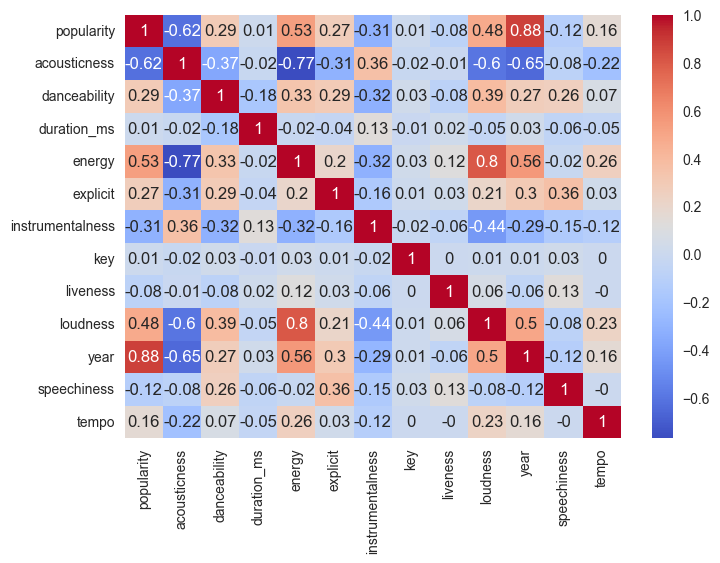

In [4]:
# Calculate the correlation matrix
corr_matrix = data[['popularity','acousticness','danceability','duration_ms','energy','explicit','instrumentalness', 'key', 'liveness', 'loudness','year','speechiness','tempo']].corr()
corr_matrix = corr_matrix.round(2)

# Plot a heatmap of the correlation matrix
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.show()

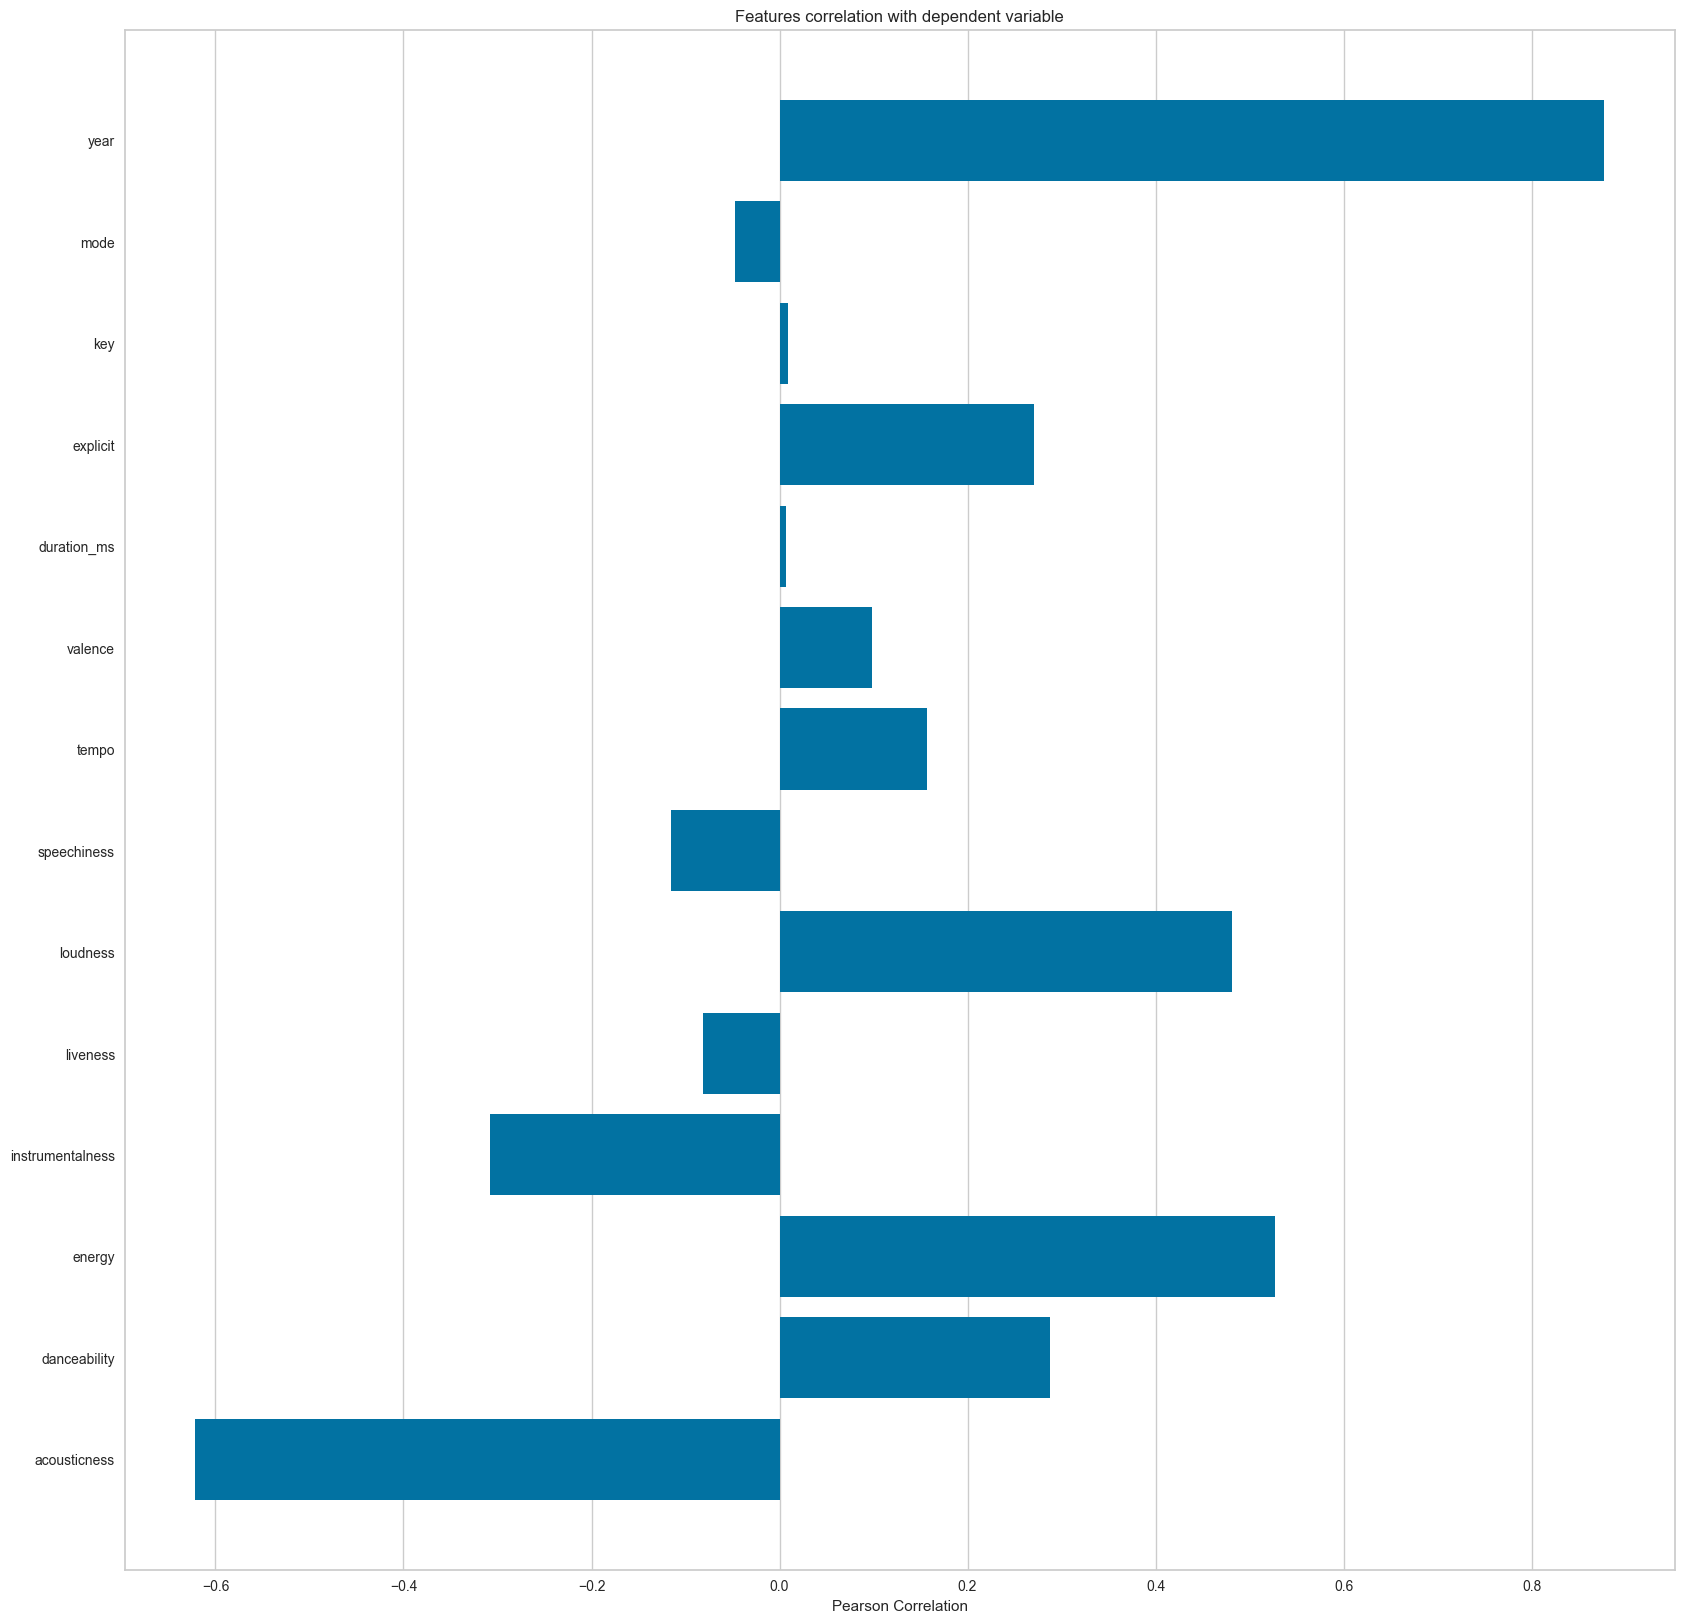

<AxesSubplot: title={'center': 'Features correlation with dependent variable'}, xlabel='Pearson Correlation'>

In [5]:
feature_names = ['acousticness', 'danceability', 'energy', 'instrumentalness',
       'liveness', 'loudness', 'speechiness', 'tempo', 'valence','duration_ms','explicit','key','mode','year']

X, y = data[feature_names], data['popularity']

# Create a list of the feature names
features = np.array(feature_names)

# Instantiate the visualizer
visualizer = FeatureCorrelation(labels=features)

plt.rcParams['figure.figsize']=(20,20)
visualizer.fit(X, y)     # Fit the data to the visualizer
visualizer.show()

Here is a another look at the correlation for the features relative to popularity. Based on this graph, we can see more clearly just what metrics are important to use in our model. 

### Examining the Genre data
For this, I wanted to explore the genre data a little more. In this instance, I wanted to see the most popular genre and based on my finding, the most popular genres were:
1. Basshall
2. South African House
3. Trap Venezolano
4. Turkish EDM
5. Alberta Hip Hop
6. Chinese electropop
7. Afroswing
8. Afro Soul
9. Circuit
10. Guaracha

I find the following list interesting for a few reasons. The first reason being that most, if not all, of the following genre a fairly minute in America. These genres are interesting because it puts our music in perspective to the rest of the world. Alot of these genres lack lyrics and are mostly electronic/computer produced rather than created through traditional instruments. Based on that, it's clear why our correlation graph showed that acousticness and instrumentalness were negatives in correlation with popularity. It also explains why energy, loudness were so high. It's also interesting to note that alot of these genres are listened to accross Europe. This also puts into perspective how connected Europe is and how different cultures can blend accross countries fairly easily where as Western music can have a harder time reaching to other countries accross the globe. 

In [6]:
data_by_genre = pd.read_csv("data_by_genres.csv", on_bad_lines="skip")
# top10_genres = data_by_genre.nlargest(10, 'popularity')

top10_genres = data_by_genre.nlargest(10, 'popularity')
top10_genres.head(10)

,mode,genres,acousticness,danceability,duration_ms,energy,instrumentalness,liveness,loudness,speechiness,tempo,valence,popularity,key
237,1,basshall,0.213167,0.81800,169799.166667,0.630167,0.000020,0.081067,-6.627833,0.134833,115.092500,0.588667,80.666667,2
2533,1,south african house,0.043833,0.84700,311854.333333,0.562333,0.130339,0.075133,-7.719000,0.050733,123.676333,0.834333,80.000000,1
2755,1,trap venezolano,0.044600,0.87700,231848.000000,0.777000,0.000035,0.086300,-4.246000,0.117000,102.020000,0.706000,80.000000,1
2778,0,turkish edm,0.008290,0.69800,186700.000000,0.719000,0.000004,0.326000,-4.923000,0.045500,120.062000,0.364000,80.000000,0
46,0,alberta hip hop,0.330000,0.88500,144000.000000,0.685000,0.000000,0.148000,-6.429000,0.062700,99.954000,0.937000,78.500000,11
536,0,chinese electropop,0.002570,0.66000,217088.000000,0.787000,0.000000,0.323000,-4.592000,0.032000,142.018000,0.199000,78.500000,1
37,0,afroswing,0.318450,0.71175,179995.375000,0.580187,0.000258,0.189950,-7.016687,0.195563,83.250125,0.676625,77.312500,11
31,0,afro soul,0.006270,0.76600,202627.000000,0.873000,0.000000,0.076400,-6.381000,0.143000,126.988000,0.743000,77.000000,11
575,1,circuit,0.009030,0.74500,189818.000000,0.972000,0.465000,0.297000,-3.506000,0.077400,128.031000,0.556000,77.000000,7
1239,1,guaracha,0.009030,0.74500,189818.000000,0.972000,0.465000,0.297000,-3.506000,0.077400,128.031000,0.556000,77.000000,7


This graph further proves my statement from earlier. These popular genres have similar features measurements which leads to the correlation graph earlier being correct.  

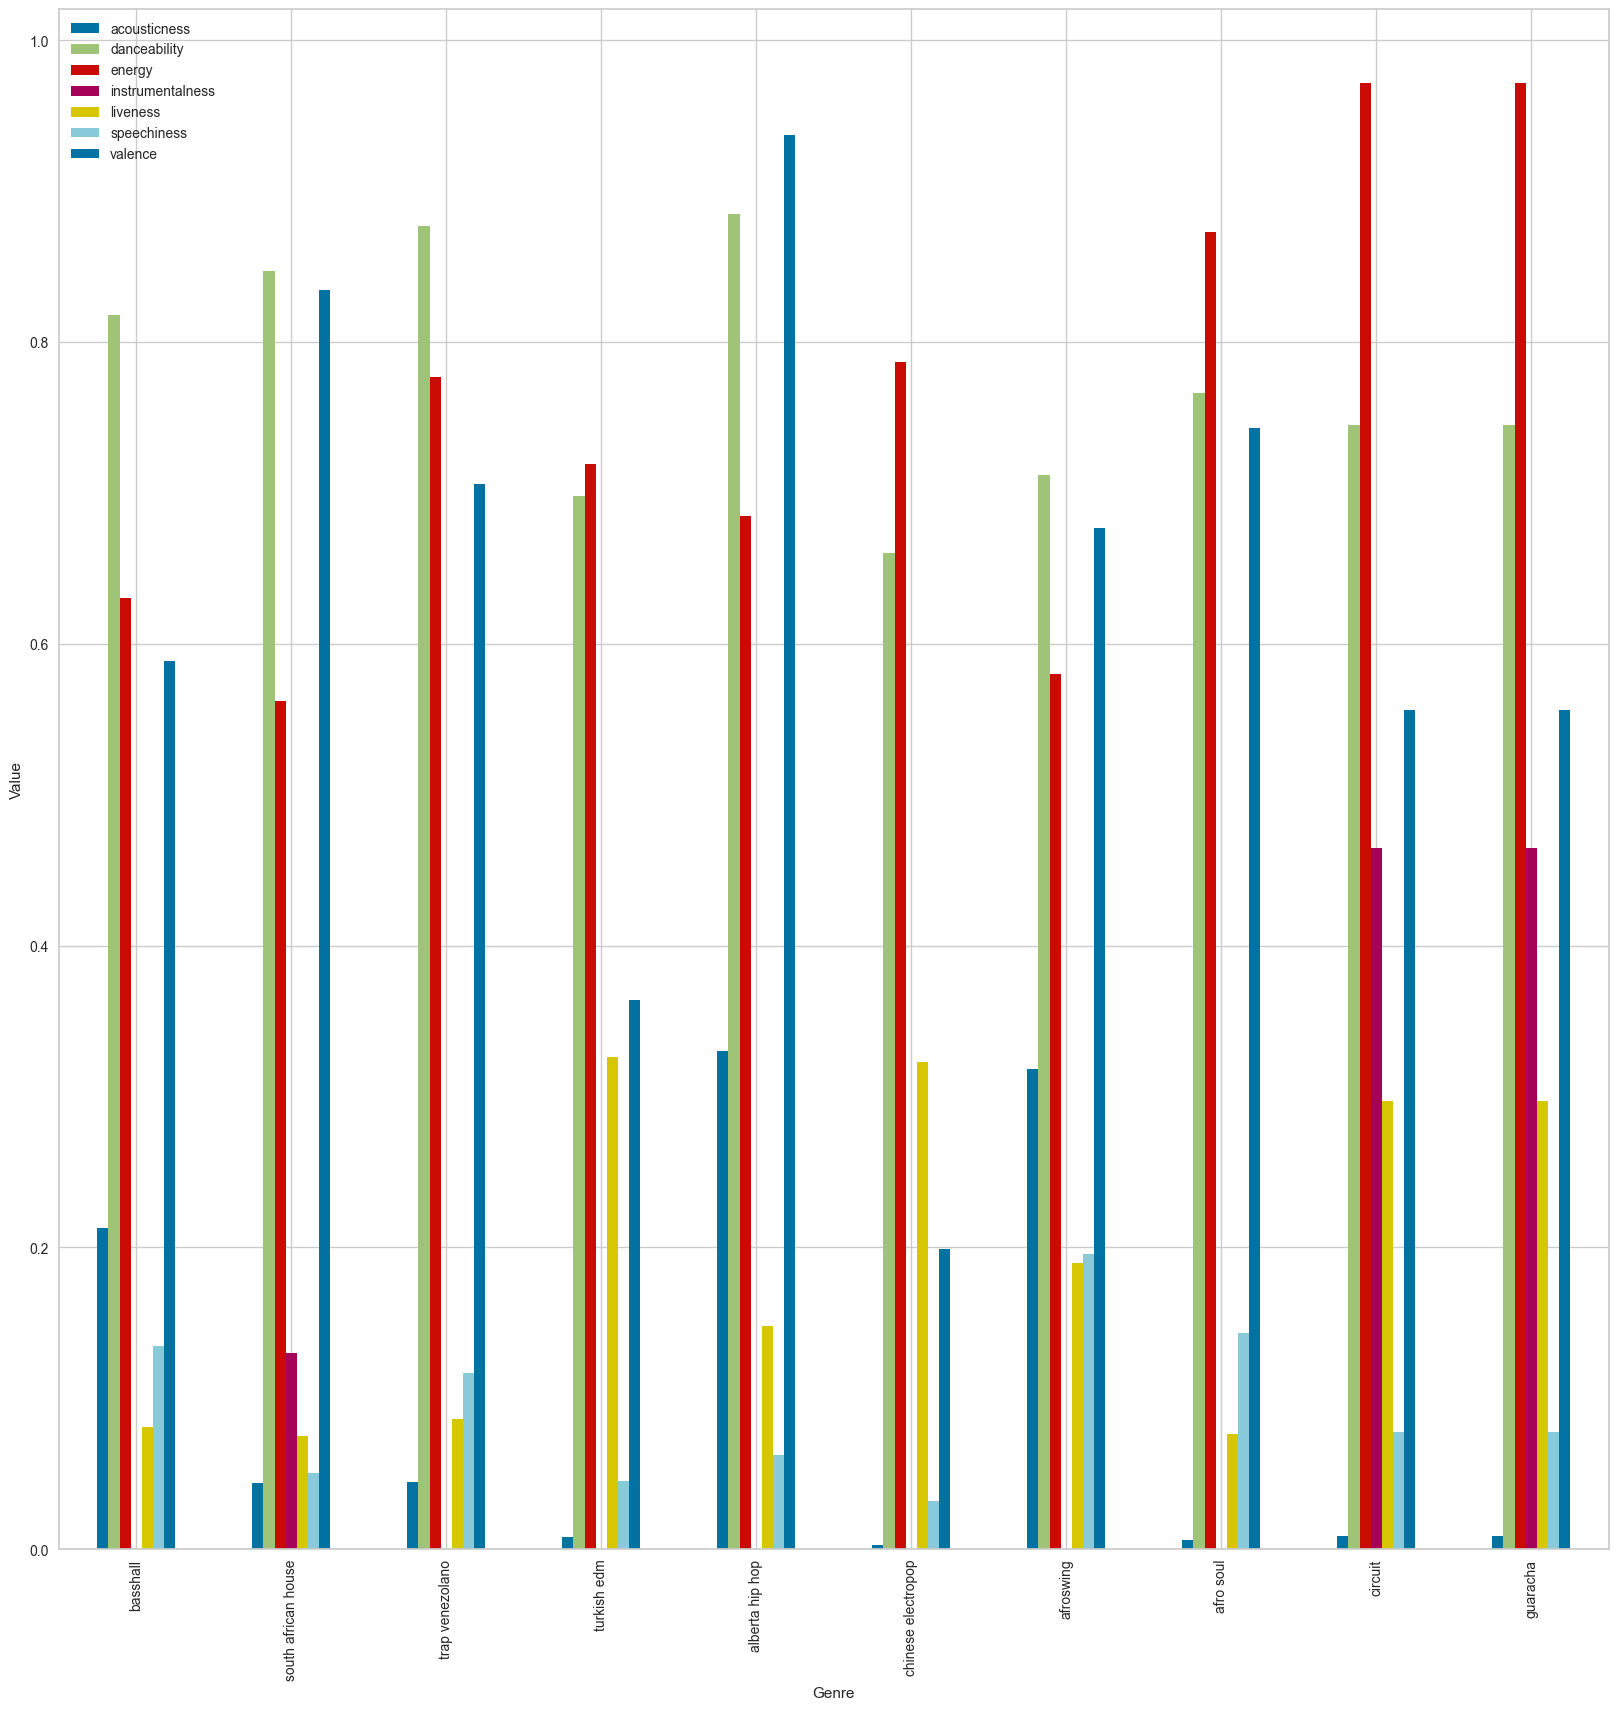

In [7]:
ax = top10_genres.plot(x='genres', y=['acousticness', 'danceability', 'energy', 'instrumentalness',
       'liveness', 'speechiness', 'valence'], kind="bar", width=0.5)
ax.set_xlabel('Genre')
ax.set_ylabel('Value')
plt.show()

### Examining the Artists Data
I felt that this data was going to be least impactful for analysis and my theory was proven correct. During my investigation, I found that the popularity for artists were all relative to the time in which the data was taken. As a result, alot of the artists listed are general artists with relative popularity and can be discounted as their popularity score isn't needed for our model 


In [8]:
artist_data = pd.read_csv('data_by_artist.csv')
top10_popular_artists = artist_data.nlargest(10, 'popularity')
top10_most_song_produced_artists = artist_data.nlargest(10, 'count')
print('Top 10 Artists that had most popularity score:')
top10_popular_artists[['popularity','artists']].sort_values('popularity',ascending=False)

Top 10 Artists that had most popularity score:


,popularity,artists
20966,93.0,Ritt Momney
14354,92.0,Lele Pons
15070,90.0,Los Legendarios
11764,89.0,Jerry Di
7463,88.0,Emilee
23687,88.0,Surf Mesa
28263,88.0,salem ilese
213,87.0,A7S
2343,86.0,Beltito
14378,86.0,Lenny Santos


### Creating the Recommendation Model
In order to create the recommendation model, there were a few different approaches I could've taken such as k-Nearest Neighbors (k-NN) or Collaborative Filtering. I however decided to use Content Based Filtering as my datasets does not include other users and I found that by normalizing my data, it would be much easier to train the model since we can use popularity as what the users likes. I also learned that there are a few different methods for CBF and as a result, I tested all of them out to see if there are any differences in the results between the models. 

Here was the steps I took to create the model:
1. Collect and preprocess data: I started by collecting a dataset of music tracks and their features. I use the publicly available datasets from earlier, which contains a large number of audio features for each track. I preprocessed the data and cleaned it. This mean removing any duplicates that might be uncessary as well as getting rid of all NaN by inner merging with other datasets. I then normalized the data based on columns/features I found most impactful to the popularity score. 

2. Define a similarity metric: To recommend songs that are similar to the input song, I need to define a similarity metric that can measure the similarity between two songs. I use a distance metric like cosine distance/Manhattan distance to calculate the similarity between two songs based on their features.



In [9]:
#Doing this to avoid model recommending covers, remasters, live versions, greatest hits, etc.
data = data.sort_values('popularity', ascending=False).drop_duplicates('name').sort_index()

df = data[['danceability','energy',"valence","speechiness","instrumentalness","acousticness", 'loudness', 'explicit', 'tempo']]
# normalized  data by columns
df_normalized = pd.DataFrame(normalize(df, axis=1))
df_normalized.columns = df.columns
df_normalized.index = data['name']
df_normalized.head()

,danceability,energy,valence,speechiness,instrumentalness,acousticness,loudness,explicit,tempo
name,,,,,,,,,
"Piano Concerto No. 3 in D Minor, Op. 30: III. Finale. Alla breve",0.003344,0.002529,0.000712,0.000439,0.010525,0.011771,-0.240895,0.0,0.970413
Clancy Lowered the Boom,0.013165,0.005481,0.015479,0.006671,0.000000,0.011766,-0.199976,0.0,0.979481
Gati Bali,0.002946,0.001491,0.000354,0.000304,0.008200,0.008631,-0.133372,0.0,0.990989
Gati Mardika,0.005785,0.002872,0.001627,0.000581,0.001394,0.004806,-0.103802,0.0,0.994563
The Wearing of the Green,0.007723,0.003027,0.006053,0.000917,0.000000,0.014849,-0.157872,0.0,0.987294


In [10]:
def recommend(song, N, method):
    allSongs = pd.DataFrame(df_normalized.index)
    allSongs = allSongs[allSongs['name'] != song]
    allSongs["distance"] = allSongs["name"].apply(lambda x: method(df_normalized.loc[song], df_normalized.loc[x]))
    # sort by distance then recipe id, the smaller value of recipe id will be picked. 
    TopNRecommendation = allSongs.sort_values(["distance"]).head(N).sort_values(by=['distance', 'name'])
    #print(data['name'].loc[song_id, :])
    Recommendation = pd.merge(TopNRecommendation , data, how='inner', on='name')
    SongName = Recommendation['name']
    res = pd.merge(SongName, data[['genres', 'artists', 'name', 'popularity', 'year']], on='name', how='left')

    return res

In [11]:
recommend("That's the Way - Remaster", 10, cityblock).head(10)

,name,genres,artists,popularity,year
0,Dawn: Dawn Is A Feeling,"[album rock, art rock, british invasion, class...",The Moody Blues,31,1967
1,Doing Alright - Remastered 2011,"[classic rock, glam rock, rock]",Queen,30,1973
2,Wild Is The Wind,"[jazz blues, soul, soul jazz, torch song, voca...",Nina Simone,49,1966
3,Falstaff: Act III: Scene 2: Naso vermiglio!,"[classical, italian opera, italian romanticism...",Giuseppe Verdi,0,1950
4,Indescreet,"[adult standards, easy listening, lounge]",Frank Sinatra,14,1962
5,Erba di mare,"[canzone napoletana, classic italian folk pop,...",Giorgio Consolini,0,1942
6,A Piece Of Sky,"[adult standards, mellow gold, soft rock]",Barbra Streisand,38,1983
7,On the Street Where You Live - Single Version,"[adult standards, brill building pop, easy lis...",Andy Williams,15,1964
8,"Verdi : Ernani : Part 1: Il bandito ""Che mai v...",[],Fernando Previtali,0,1951
9,Ora stammi a sentir,[opera],Francesco Molinari-Pradelli,0,1952


In [12]:
recommend("That's the Way - Remaster", 10, euclidean).head(10)

,name,genres,artists,popularity,year
0,Doing Alright - Remastered 2011,"[classic rock, glam rock, rock]",Queen,30,1973
1,Dawn: Dawn Is A Feeling,"[album rock, art rock, british invasion, class...",The Moody Blues,31,1967
2,A Piece Of Sky,"[adult standards, mellow gold, soft rock]",Barbra Streisand,38,1983
3,I'm Thru With Love,"[adult standards, jazz blues, lounge, soul, sw...",Dinah Washington,21,1959
4,Sea Song,"[art rock, british folk, canterbury scene, exp...",Robert Wyatt,24,1974
5,Close Every Door To Me,"[broadway, show tunes, west end]",Andrew Lloyd Webber,42,1991
6,Jivaro,"[exotica, lounge, space age pop]",Yma Sumac,28,1957
7,"Die Walküre, WWV 86B: Act I: Scene 3: Der Männ...","[classical performance, historic orchestral pe...",Arturo Toscanini,0,1952
8,On the Street Where You Live - Single Version,"[adult standards, brill building pop, easy lis...",Andy Williams,15,1964
9,Two Of Us,"[album rock, art rock, classic rock, glam rock...",Supertramp,34,1975


In [13]:
recommend("Get Back - Remastered 2009", 10, cosine).head(10)

,name,genres,artists,popularity,year
0,Nobody (feat. Athena Cage),[],Athena Cage,64,1996
1,The Crying Clown,"[album rock, art rock, blues rock, british blu...",Peter Frampton,24,1975
2,Ten Cent Pistol,"[alternative rock, blues rock, garage rock, mo...",The Black Keys,50,2010
3,What Kind Of Man Would I Be,"[funk, hip pop, minneapolis sound, neo soul, n...",Mint Condition,50,1996
4,Hands,"[hip hop, political hip hop]",Jewel,54,1998
5,Two Worlds Finale,"[mellow gold, rock drums, soft rock]",Phil Collins,42,1999
6,La chispa adecuada (Bendecida 3),"[latin alternative, latin rock, musica aragone...",Heroes Del Silencio,63,1995
7,Still Your Best,[alternative r&b],Giveon,67,2020
8,Home On Monday - 2010 Digital Remaster,"[album rock, art rock, australian rock, classi...",Little River Band,44,1977
9,The Baby,"[contemporary country, country, country road, ...",Blake Shelton,45,2003


### Conclusion
After creating both models for both different types of distances for my normalized data, I found something interesting. For the first model, I used the Manhattan Distnce. I did this because I realized that the measurements for my datasets were fairly different, so my first choice was this method for distance. My second choice was euclidean and my third was cosine. I found that all 3 distance of method were all fairly similar, producing results certain results as expected. However, I did find that remastered music with later release dates can force the model to change the results heavily. For instance...

In [15]:
recommend("Get Back - Remastered 2015", 10, cosine).head(10)

,name,genres,artists,popularity,year
0,Be Blessed,"[gospel, gospel r&b]",Yolanda Adams,44,2005
1,Take on the World,"[modern alternative rock, modern rock, neon po...",You Me At Six,67,2017
2,Still Rolling Stones,"[ccm, christian alternative rock, christian mu...",Lauren Daigle,63,2018
3,And Our Feelings,"[dance pop, neo soul, new jack swing, quiet st...",Babyface,34,1993
4,Love Is A Wild Thing,"[contemporary country, country dawn, pop, texa...",Kacey Musgraves,58,2018
5,Tonight,"[pop, r&b]",Summer Walker,63,2019
6,18,"[boy band, pop, post-teen pop, talent show]",One Direction,81,2014
7,Lloran las Rosas,"[latin, latin arena pop, latin pop]",Cristian Castro,38,1997
8,Sundream,"[australian electropop, edm, indietronica]",RÜFÜS DU SOL,61,2013
9,Down In the Flood,"[blues, blues rock, classic rock, country rock...",The Derek Trucks Band,48,2009


Here, we see a completely different set of recommended songs. This is because of what we found earlier regarding how much year can impact the songs that gets recommended. I have no doubt these songs can sound familiar to the input but a certain lack, or in this case, a large amount of certainty can make the model predict wrong music. I'm not a music expert but I don't think I would want to listen to latin music after The Beatles' Get Back.

In conclusion, I found that the series of findings as well as the models very interesting. I learned a lot about how Spotify is potentially recommeding me new music, as well as old ones I might be familiar with. I also learned about the of the exciting features and how each and every single one of them can play a role in the current Spotify user base. All of this combine for what is a really in depth look on Spotify's music recommendation and I look forward to using my learning from this project in the future.